# <center> <u> Linear Regression Loss Functions </u> </center>

## 1. <u> Squared Error Loss </u> 

#### - Highly sensitive to outliers 

## 2. <u> Log Cosh Loss </u> 

#### - Differentiable, approximately linear 

## 3. <u> Huber Loss </u> 

#### - Outlier threshold parameter

## 4. <u> Squared Logarithmic Error Loss </u> 

#### - Concave outliers

In [1]:
import numpy as np
import pandas as pd 

from numba import jit, prange
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt 

## <center> Set Seaborn Theme </center>

In [2]:
sns.set_theme(
    style = "darkgrid",
    palette = "bright",
)

plt.rc('figure', figsize = (10, 5))

## <center> Generate Synthetic Data </center> 

In [3]:
@jit(nopython = True, parallel = True)
def compute_cholesky_decomposition(p):
    """
    
    """
    
    N = 1000
    x1 = np.zeros(N)
    x2 = np.zeros(N)
    
    z1 = np.random.normal(0, 1, N)
    z2 = np.random.normal(0, 1, N)
    
    x1 = z1
    
    for i in prange(N):
        x2[i] = p * z1[i] + np.sqrt(1 - p**2) * z2[i]
    
    
    return x1, x2

In [4]:
@jit(nopython = True)
def gaussian_distribution(x):
    """
    
    """
    
    mu = 0
    sigma = 1
    
    z = ((x - mu) / sigma)**2
    
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * z)

In [5]:
@jit(nopython = True)
def lalpacian_distribution(x):
    """
    
    """
    
    mu = 0 
    b = 1
    
    return (1 / (2 * b)) * np.exp(-np.abs(x - mu) / b)

In [6]:
@jit(nopython = True)
def gumbel_distribution(x):
    """
    
    """
    
    mu = -1
    beta = 1
    
    z = (x - mu) / beta
    
    return (1 / beta) * np.exp(-(z + np.exp(-z)))

In [7]:
@jit(nopython = True)
def simpsons_rule(pdf, X):
    """
    
    """
    
    area = 0
    integral = np.copy(pdf)
    
    for i in range(1, len(pdf)):
        area += (X[i] - X[i-1]) / 6 * (pdf[i] + 4 * ((pdf[i] + pdf[i-1]) / 2) + pdf[i-1])
        integral[i] = area
    
    return integral

In [8]:
x1 = np.linspace(-6, 12, 1000)

fx = np.copy(x1)
for i in range(len(x1)):
    fx[i] = gumbel_distribution(x1[i])

fx_cdf = simpsons_rule(fx, x1)

x2 = np.linspace(-12, 12, 1000)

gx = np.copy(x2)
for i in range(len(x2)):
    gx[i] = lalpacian_distribution(x2[i])
    
gx_cdf = simpsons_rule(gx, x2)

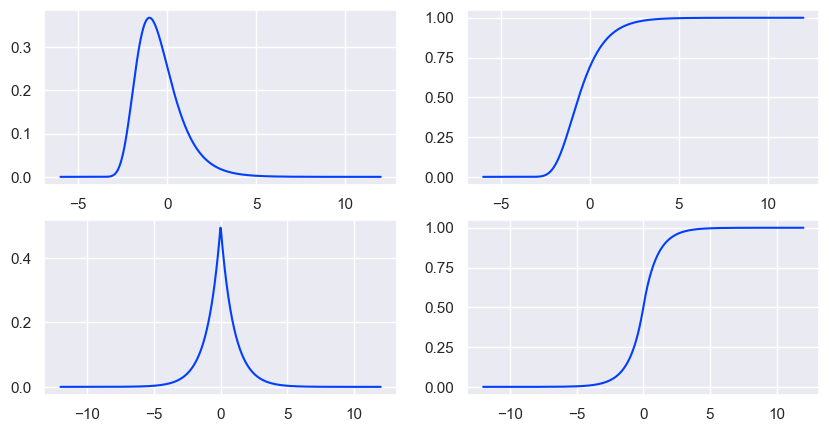

In [9]:
fig, axes = plt.subplots(2, 2)

sns.lineplot(
    x = x1,
    y = gumbel_distribution(x1),
    ax = axes[0, 0],
)

sns.lineplot(
    x = x1,
    y = fx_cdf,
    ax = axes[0, 1],
)

sns.lineplot(
    x = x2,
    y = lalpacian_distribution(x2),
    ax = axes[1, 0],
)

sns.lineplot(
    x = x2,
    y = gx_cdf,
    ax = axes[1, 1],
)

plt.show()

In [10]:
@jit(nopython = True)
def compute_inverse_cdf(func, integral):
    """
    Input: 
    - Probability Density Function 
    
    Output:
    - Inverse Value from CDF
    """
    
    a = -12
    b = 12
    c = (a + b) / 2
    
    err_tol = 1e-7
    max_itr = 1000
            
    N = 1000
    interval = np.linspace(-12, c, N)
    func_c = np.zeros(N)
    
    for i in range(N):
        func_c[i] = func(interval[i])  
        
    c_cdf = simpsons_rule(func_c, interval)[-1]

    itr_count = 0
    while np.abs(c_cdf - integral) > err_tol and itr_count < max_itr:
    
        if c_cdf < integral:
            a = c
            c = (a + b) / 2
            
        if c_cdf > integral: 
            b = c
            c = (a + b) / 2

        interval = np.linspace(-12, c, N)
        func_c = np.zeros(N)
        
        for i in range(len(interval)):
            func_c[i] = func(interval[i])
            
        c_cdf = simpsons_rule(func_c, interval)[-1]
    
        itr_count += 1
        
    if itr_count >= max_itr:
        print("Max Iteration Count")
        return 0
    
    return c

In [11]:
@jit(nopython = True)
def compute_inverse(func, integral):
    """
    Wrapper Method that Call Custom Bisection Method for Inverse CDF
    """
    
    root = compute_inverse_cdf(func, integral)
    
    return root

In [12]:
@jit(nopython = True, parallel = True)
def compute_copula(rho):
    """
    
    """
    
    x, y = compute_cholesky_decomposition(rho)
    N = len(x)
    
    x1 = np.zeros(N)
    y1 = np.zeros(N) 
    
    for i in prange(N):
        
        interval = np.linspace(-12, x[i], 1000)
        tmp_fx = gaussian_distribution(interval)
        integral = simpsons_rule(tmp_fx, interval)[-1]
        x1[i] = compute_inverse(gumbel_distribution, integral)
        
        interval = np.linspace(-12, y[i], 1000)
        tmp_gx = gaussian_distribution(interval)
        integral = simpsons_rule(tmp_gx, interval)[-1]
        y1[i] = compute_inverse(lalpacian_distribution, integral)
            
    return x1, y1

In [13]:
x1, y1 = compute_copula(0.7)

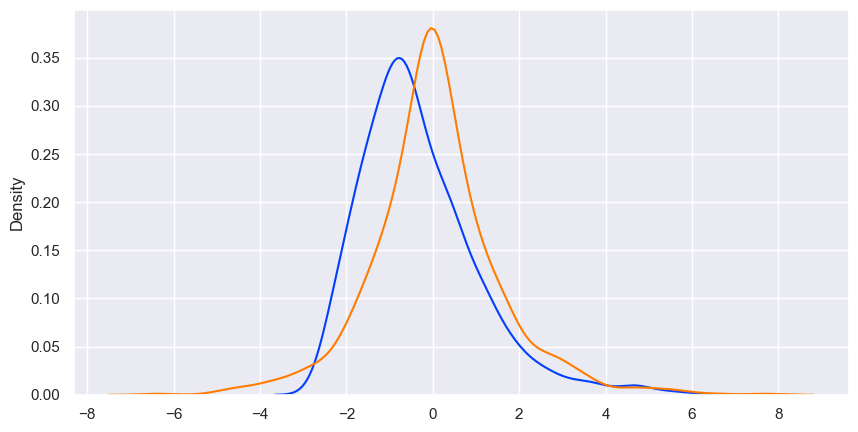

In [14]:
ax = sns.kdeplot(
    x1,
    label = "f(x)",
)

sns.kdeplot(
    y1,
    label = "g(x)",
)

plt.show()

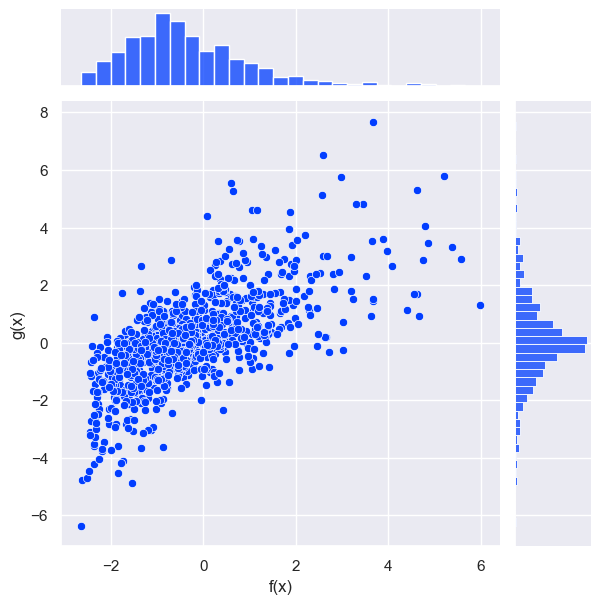

In [15]:
ax = sns.jointplot(
    x = x1, 
    y = y1,
)

ax.set_axis_labels('f(x)', 'g(x)')

plt.show()

In [16]:
@jit(nopython = True)
def generate_data(rho):
    """
    
    """
    X = {}
    y = {}

    for i in range(len(rho)):
        X[rho[i]], y[rho[i]] = compute_copula(rho[i])
            
    return X, y

In [17]:
rho = np.arange(0.05, 1.05, 0.05)
X, y = generate_data(rho)
keys = list(X.keys())

## <center> Coefficient of Determination </center>

## <center> $ R^2 = 1 - \frac{\sum_{i=1}^{N} (y_{i} - f_{i})^2}{\sum_{i=1}^{N} (y_{i} - \hat{y})^2} $ </center>

In [18]:
@jit(nopython = True, parallel = True)
def compute_r2(y, y_hat):
    """
    
    """
    
    RSS = np.sum((y - y_hat)**2)
    TSS = np.sum((y_hat - np.mean(y_hat))**2)
    
    R2 = 1 - (RSS / TSS)
    
    return R2

## <center> Squared Error </center> 

## <center> $ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x})^{2} $ </center> 

## <center> $ \nabla(\beta) = \frac{2}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x}) \cdot x_{i} $ </center> 

## <center> $ H(\beta) = \frac{2}{N} \sum_{i=1}^{N} x_{i}^{2} $ </center>

In [19]:
@jit(nopython = True, parallel = True)
def squared_error_regression(X, y):
    """
    
    """
    
    err_tol = 1e-7
    L = len(X)
    
    beta = 0.5
    gamma = 1
    gradient = 1
    itr_count = 0
    max_itr = 100
    
    while np.abs(gradient) > err_tol and itr_count < max_itr:
        
        for i in prange(L):
            gradient += ((X[i] * beta) - y[i]) * X[i]
            gamma += X[i]**2

        gradient *= 2 / L
        gamma *= 2 / L
        beta = beta - (gradient / gamma)
        itr_count += 1
    
    print("Iteration Count: ", itr_count)
    
    return beta

In [20]:
squared_estimates = []
squared_scores = []

for k in keys:
    tmp_beta = squared_error_regression(X[k], y[k])
    squared_estimates.append(tmp_beta)
    
    interval = X[k]
    tmp_prediction = interval * tmp_beta
    tmp_r2 = compute_r2(tmp_prediction, y[k])
    squared_scores.append(tmp_r2)

Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6


## <center> Log Cosh </center>

## <center> $ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} log(cosh((x_{i} \beta) - \hat{x})) $ </center>

## <center> $ \nabla(\beta) = \frac{1}{N} \sum_{i=1}^{N} tanh((x_{i} \beta) - \hat{x}) \cdot x_{i} $ </center>

## <center> $ H(\beta) = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{cosh^{2}((x_{i} \beta) - \hat{x})} x_{i}^{2} $ </center>

In [21]:
@jit(nopython = True, parallel = True)
def log_cosh_error_regression(X, y):
    """
    
    """
    
    err_tol = 1e-7
    
    L = len(X)
    beta = 0.5
    gamma = 1
    gradient = 1
    itr_count = 0
    max_itr = 100
    
    while np.abs(gradient) > err_tol and itr_count < max_itr:
        
        for i in prange(L):
            gradient += np.tanh((X[i] * beta) - y[i]) * X[i]
            gamma += (1 / np.cosh((X[i] * beta) - y[i]))**2 * X[i]**2

        gradient *= 1 / L
        gamma *= 1 / L
        beta = beta - (gradient / gamma)
        itr_count += 1
    
    print("Log Cosh Error Regression Iteration Count: ", itr_count)
    
    return beta

In [22]:
log_cosh_estimates = []
log_cosh_scores = []

for k in keys:
    tmp_beta = log_cosh_error_regression(X[k], y[k])
    log_cosh_estimates.append(tmp_beta)
    
    interval = X[k]
    tmp_prediction = interval * tmp_beta
    tmp_r2 = compute_r2(tmp_prediction, y[k])
    log_cosh_scores.append(tmp_r2)

Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  5
Log Cosh Error Regression Iteration Count:  5
Log Cosh Error Regression Iteration Count:  5
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  6
Log Cosh Error Regression Iteration Count:  7


## <center> Huber Loss </center> 

## <center> $ L(\theta) = \begin{cases}
        \frac{1}{N} \sum_{i=1}^{N} \frac{1}{2} ((x_{i} \beta) - \hat{x})^2 & \text{if } |(x_{i} \beta) - \hat{x}| \leq \delta \\
        \frac{1}{N} \sum_{i=1}^{N} \delta (|(x_{i} \beta) - \hat{x}| - \frac{1}{2} \delta) & \text{if } |(x_{i} \beta) - \hat{x}| \gt \delta
    \end{cases} $ </center> 
    
## <center> $ \nabla(\beta) = \begin{cases}
        \frac{1}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x}) \cdot x_{i} & \text{if } |(x_{i} \beta) - \hat{x}| \leq \delta \\
        \frac{1}{N} \sum_{i=1}^{N} \frac{\delta ((x_{i} \beta) - \hat{x})}{|(x_{i} \beta) - \hat{x}|} \cdot x_{i} & \text{if } |(x_{i} \beta) - \hat{x}| \gt \delta
    \end{cases} $ </center> 
    
## <center> $ H(\beta) = \begin{cases}
        \frac{1}{N} \sum_{i=1}^{N} x_{i}^{2} & \text{if } |(x_{i} \beta) - \hat{x}| \leq \delta \\
        \frac{1}{N} \sum_{i=1}^{N} 0 & \text{if } |(x_{i} \beta) - \hat{x}| \gt \delta
    \end{cases} $ </center> 

In [23]:
@jit(nopython = True, parallel = True)
def huber_error_regression(X, y, delta):
    """
    
    """
    
    err_tol = 1e-7
    
    L = len(X)
    beta = 0.5
    gamma = 1
    gradient = 1
    itr_count = 0
    
    while np.abs(gradient) > err_tol:
        
        for i in prange(L):
            
            x = np.abs(X[i] * beta - y[i])
            
            if x <= delta:
                gradient += (X[i] * beta - y[i]) * X[i]
                gamma += X[i]**2
            else:
                gradient += (delta * (X[i] * beta - y[i])) / (np.abs((X[i] * beta - y[i]))) * X[i]
                gamma += 0

        gradient *= 1 / L
        gamma *= 1 / L
        beta = beta - (gradient / gamma)
        itr_count += 1
    
    print("Huber Error Regression Iteration Count: ", itr_count)
    
    return beta

In [24]:
huber_loss_estimates = []
huber_scores = []

for k in keys:
    tmp_beta = huber_error_regression(X[k], y[k], delta = 3)
    huber_loss_estimates.append(tmp_beta)
    
    interval = X[k]
    tmp_prediction = interval * tmp_beta
    tmp_r2 = compute_r2(tmp_prediction, y[k])
    huber_scores.append(tmp_r2)

Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  5
Huber Error Regression Iteration Count:  5
Huber Error Regression Iteration Count:  5
Huber Error Regression Iteration Count:  5
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6
Huber Error Regression Iteration Count:  6


## <center> Squared Logarithmic Error </center> 

## <center> $ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} log(((x_{i} \beta) - \hat{x})^{2} + 1) $ </center>

## <center> $ \nabla(\beta) = \frac{1}{N} \sum_{i=1}^{N} \frac{2 x_{i} ((x_{i} \beta) - \hat{x})}{(x_{i} \beta) - \hat{x})^{2} + 1} $ </center>

## <center> $ H(\beta) = \frac{1}{N} \sum_{i=1}^{N} \frac{2 x_{i} (-\beta^{2} x_{i}^{3} + 2 \beta x_{i}^{2} \hat{x} - \hat{x}^{2} x_{i} + x_{i})}{((x_{i} \beta) - \hat{x})^{2} + 1)^{2}} $ </center>

In [25]:
@jit(nopython = True, parallel = True)
def squared_log_error_regression(X, y):
    """
    
    """
    
    err_tol = 1e-7
    
    L = len(X)
    beta = 0.5
    gamma = 1
    gradient = 1
    itr_count = 0
    
    while np.abs(gradient) > err_tol:
        
        for i in prange(L):
            gradient += (2 * X[i] * ((X[i] * beta) - y[i])) / (((X[i] * beta) - y[i])**2 + 1)
            gamma += (2 * X[i] * ((-beta**2 * X[i]**3) + (2 * beta * X[i]**2 * y[i]) - (X[i] * y[i]**2) + X[i])) / (((X[i] * beta) - y[i])**2 + 1)**2

        gradient *= 1 / L
        gamma *= 1 / L
        beta = beta - (gradient / gamma)
        itr_count += 1
    
    print("Squared Log Error Regression Iteration Count: ", itr_count)
    
    return beta

In [26]:
squared_log_estimates = []
squared_log_scores = []

for k in keys:
    tmp_beta = squared_log_error_regression(X[k], y[k])
    squared_log_estimates.append(tmp_beta)
    
    interval = X[k]
    tmp_prediction = interval * tmp_beta
    tmp_r2 = compute_r2(tmp_prediction, y[k])
    squared_log_scores.append(tmp_r2)

Squared Log Error Regression Iteration Count:  7
Squared Log Error Regression Iteration Count:  7
Squared Log Error Regression Iteration Count:  7
Squared Log Error Regression Iteration Count:  7
Squared Log Error Regression Iteration Count:  7
Squared Log Error Regression Iteration Count:  7
Squared Log Error Regression Iteration Count:  7
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  5
Squared Log Error Regression Iteration Count:  5
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6
Squared Log Error Regression Iteration Count:  6


## <center> Aggregate Results to DataFrame </center> 

In [27]:
df = pd.DataFrame({
    "Squared Loss" : squared_estimates,
    "Log Cosh Loss" : log_cosh_estimates,
    "Huber Loss" : huber_loss_estimates,
    "Squared Log Loss" : squared_log_estimates,
}, index = rho)

In [28]:
display(df)

,Squared Loss,Log Cosh Loss,Huber Loss,Squared Log Loss
0.05,0.072564,0.044216,0.059820,0.027931
0.10,0.079891,0.054234,0.068772,0.036619
0.15,0.117662,0.110830,0.113224,0.110993
0.20,0.175828,0.141354,0.164399,0.115976
0.25,0.192334,0.158490,0.186536,0.125893
0.30,0.218839,0.167536,0.203185,0.130882
0.35,0.322214,0.261067,0.306301,0.214545
0.40,0.381101,0.327557,0.364225,0.293337
0.45,0.478878,0.400151,0.459904,0.348529
0.50,0.486816,0.397914,0.464169,0.326906


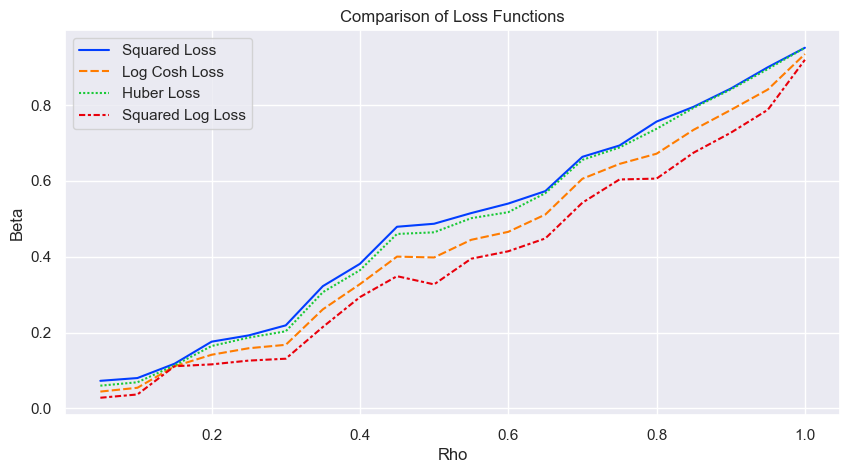

In [29]:
ax = sns.lineplot(df)

ax.set(
    title = "Comparison of Loss Functions",
    xlabel = "Rho",
    ylabel = "Beta",
)

plt.show()

## <center> Coefficient of Determination </center> 

In [30]:
df = pd.DataFrame({
    "Theoretical Correlation" : rho,
    "Squared Loss R2" : np.sqrt(squared_scores),
    "Log Cosh Loss R2" : np.sqrt(log_cosh_scores),
    "Huber Loss R2" : np.sqrt(huber_scores),
    "Squared Log Loss R2" : np.sqrt(squared_log_scores),
}, index = rho)

In [31]:
display(df)

,Theoretical Correlation,Squared Loss R2,Log Cosh Loss R2,Huber Loss R2,Squared Log Loss R2
0.05,0.05,0.049307,0.041737,0.047874,0.026881
0.10,0.10,0.066637,0.062880,0.065948,0.055284
0.15,0.15,0.118769,0.118554,0.118678,0.118564
0.20,0.20,0.162639,0.159443,0.162291,0.152803
0.25,0.25,0.187930,0.184997,0.187845,0.176357
0.30,0.30,0.204556,0.198753,0.204022,0.186988
0.35,0.35,0.305064,0.299485,0.304689,0.287415
0.40,0.40,0.349596,0.346126,0.349253,0.340191
0.45,0.45,0.443240,0.437200,0.442891,0.426478
0.50,0.50,0.451023,0.443429,0.450535,0.425962


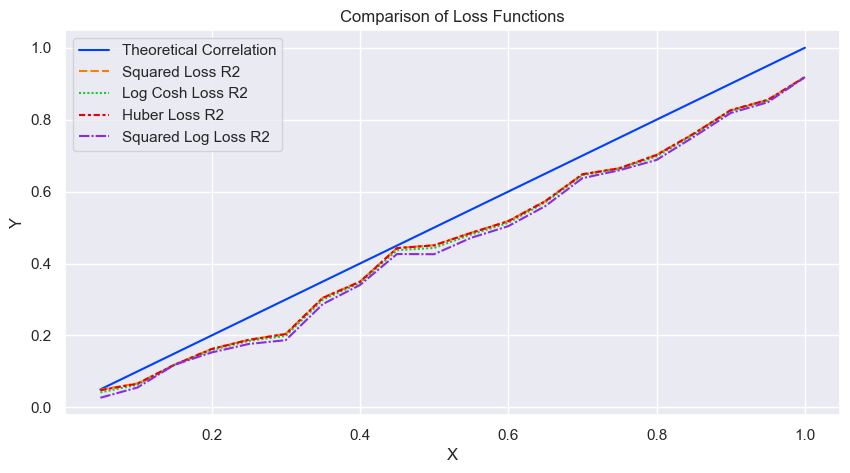

In [32]:
ax = sns.lineplot(df)

ax.set(
    title = "Comparison of Loss Functions",
    xlabel = "X",
    ylabel = "Y",
)

plt.show()

## <center> Actual vs. Theoretical </center>

In [33]:
df = pd.DataFrame({
    "Squared Loss" : (np.sqrt(squared_scores) - rho)**2,
    "Log Cosh Loss" : (np.sqrt(log_cosh_scores) - rho)**2,
    "Huber Loss" : (np.sqrt(huber_scores) - rho)**2,
    "Squared Log Loss" : (np.sqrt(squared_log_scores) - rho)**2,
}, index = rho)

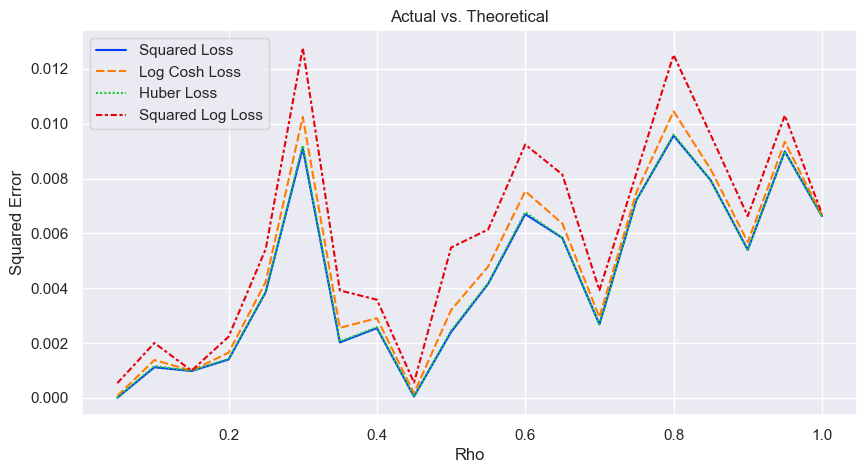

In [34]:
ax = sns.lineplot(df)

ax.set(
    title = "Actual vs. Theoretical",
    xlabel = "Rho",
    ylabel = "Squared Error",
)

plt.show()